# Generative Forecast

* This notebook loads a pre-trained time series model to make forecast with minimal testing data. 

* Model takes previous lags to autoregressively make forecast. Last forecast is appended to initial data.
    * This can be repeted with indefinately but forecasts are less accurate as steps increase.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.transformer import GPTTimeSeries

import os
import random
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

# Airline Passgeners Dataset

In [2]:
df_full = pd.read_csv('airline-passengers.csv')
df_full.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df_full['Month'] = pd.to_datetime(df_full['Month'])
df_full.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
df_full.set_index('Month', inplace=True)
df_full.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Month'>

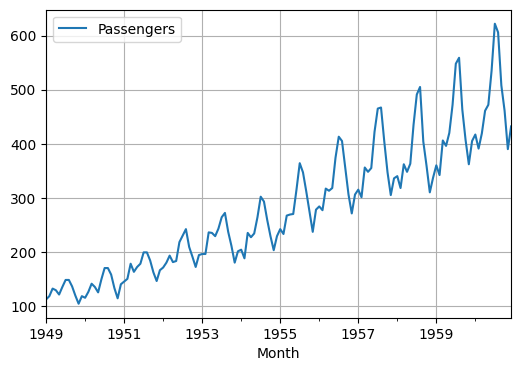

In [5]:
df_full.plot()

# Standart Scaler
* Exercise: Try without scaler, see if learning works!

<Axes: xlabel='Month'>

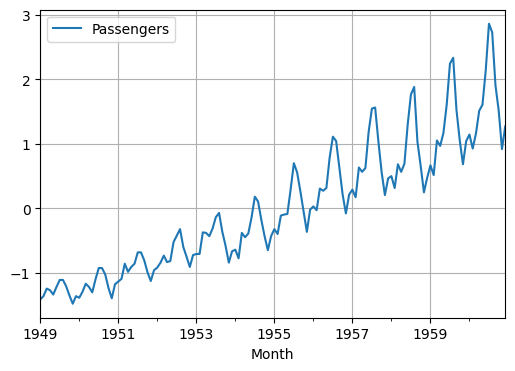

In [6]:
scaler = StandardScaler()

df_full['Passengers'] = scaler.fit_transform(df_full['Passengers'].values.reshape(-1, 1))
df_full.plot()

### Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [7]:
df_full.shape

(144, 1)

# Load Saved Checkpoint

In [8]:
checkpoint = torch.load('./saved_models/GPTTimeSeries.pt')
checkpoint.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict', 'hyperparameters'])

# Load Saved (Pre-trained) Model

In [9]:
hyperparameters = checkpoint['hyperparameters']
hyperparameters.keys()

dict_keys(['lags', 'forecast', 'input_features_size', 'hidden_features_size', 'output_features_size', 'num_heads', 'ff_dim', 'num_decoder_layers', 'emb_dropout_prob', 'attn_dropout_prob', 'ff_dropout_prob', 'attn_use_bias', 'ff_use_bias', 'output_features_bias', 'batch_size', 'split_ratio', 'learning_rate', 'num_epochs', 'window_size'])

In [10]:
model = GPTTimeSeries(
    input_features_size=hyperparameters['input_features_size'],
    features_dim=hyperparameters['hidden_features_size'],
    output_features_size=hyperparameters['output_features_size'],
    forecast_size=hyperparameters['forecast'],
    num_heads=hyperparameters['num_heads'],
    ff_dim=hyperparameters['ff_dim'],
    num_decoder_layers=hyperparameters['num_decoder_layers'],
    emb_dropout_prob=hyperparameters['emb_dropout_prob'],
    attn_dropout_prob=hyperparameters['attn_dropout_prob'],
    ff_dropout_prob=hyperparameters['ff_dropout_prob'],
    attn_use_bias=hyperparameters['attn_use_bias'],
    ff_use_bias=hyperparameters['ff_use_bias'],
    output_features_bias=hyperparameters['output_features_bias'],
)

In [11]:
model.load_state_dict(checkpoint['model_state_dict'], strict=True)

<All keys matched successfully>

# Generative Forecast

In [12]:
@torch.no_grad()
def generative_forecast(model, data, num_steps, lag_window_size):
    model.eval()
    
    predictions = []
    time_indexes = []

    _device = next(model.parameters()).device
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=_device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    timestamps = df_full.index
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]
    
    # single step
    for idx in range(num_steps):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)
        
        forecast_pred = model(lags)
        
        predictions.append(forecast_pred)

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)

        # append last forecast to the end
        lags = torch.cat((lags, forecast_pred.detach()), dim=1)

    return predictions, time_indexes

<Axes: >

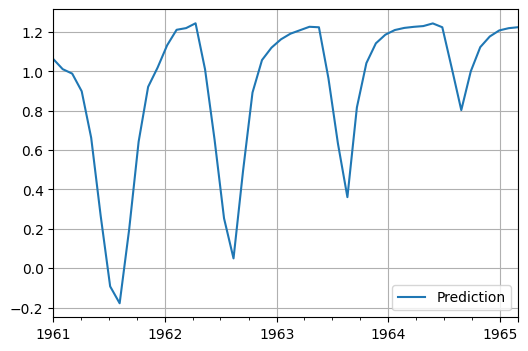

In [13]:
pred_generative, time_indexes_generative = generative_forecast(model, df_full.values, 50, hyperparameters['lags'])

pred_generative_flat = []

for p in pred_generative:
    pred_generative_flat.extend(p.flatten().tolist())


generative_results_dict = {
    'Prediction': pred_generative_flat
}

df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)
df_generative.plot()